# Cisco - Ariel University API Security Detection Challenge 2023
## Baseline code


### Imports and global settings

In [1]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_number = 1 # Options are [1, 2, 3, 4]
test_type = 'label' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(f'./dataset_{str(dataset_number)}_train.json') as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# Shoe the first five lines of the dataframe to see if everything was read accordingly 
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,request.Attack_Tag,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie
0,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,,Directory Traversal,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",NaN,NaN,NaN,NaN
1,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,,NaN,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN
2,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/cookielogin,,Cookie Injection,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,NaN,NaN,NaN
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/states/get/region/6117,,NaN,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",NaN,NaN,NaN,NaN
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document${jndi:ldaphttps://mitsui-jyuku.mixh.j...,['ck=vGDsymCRgtDms448zxnOurIjvy46d_4aAGJRG6gmh...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2508,,LOG4J,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN


### Basic dataset label arrangements

In [2]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# This function will be used in the lambda below to iterate over the label columns 
# You can use this snippet to run your own lambda on any data with the apply() method
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign':
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)
# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)

df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",NaN,NaN,NaN,NaN,Directory Traversal,Malware
1,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/cookielogin,,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,NaN,NaN,NaN,Cookie Injection,Malware
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/states/get/region/6117,,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",NaN,NaN,NaN,NaN,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document${jndi:ldaphttps://mitsui-jyuku.mixh.j...,['ck=vGDsymCRgtDms448zxnOurIjvy46d_4aAGJRG6gmh...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2508,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",NaN,NaN,NaN,NaN,LOG4J,Malware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4277,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537....,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,websocket,?1,document,['ck=wKm-iDQeCXGjwXGrGJvfzWzs5VYbnWSP75B6BjFz1...,"Mon, 21 Nov 2022 18:39:51 GMT",POST,http://127.0.0.1:5000/cookielogin,,302 FOUND,text/html; charset=utf-8,211,302,<!doctype html>\n<html lang=en>\n<title>Redire...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,/cookielogin,0,username=gASVKgAAAAAAAACMCF9fbWFpbl9flIwGUGVyc...,Cookie Injection,Malware
4278,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=oyXTP1KfNdMwWb_jIYEQYKzE9RZALsuCGCtJtUlju...,"Mon, 21 Nov 2022 18:39:51 GMT",GET,http://127.0.0.1:5000/orders/get/id/7668,,404 NOT FOUND,application/json,36,404,"{""error"": ""Order ID not found""}",NaN,NaN,NaN,NaN,Benign,Benign
4279,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=bfYOeMnpxlFA9F7ObPemhCXYmeYNbBteewfAWbnfy...,"Mon, 21 Nov 2022 18:39:52 GMT",POST,http://127.0.0.1:5000/cookielogin,,302 FOUND,text/html; charset=utf-8,211,302,<!doctype html>\n<html lang=en>\n<title>Redire...,username=gASVyAAAAAAAAACMCGJ1aWx0aW5zlIw

In [3]:
# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in df.columns[df.isna().any()].tolist():
    # df.drop(column, axis=1, inplace=True)
    df[column] = df[column].fillna('None')
    
# If you want to detect columns that may have only some NaN values use this:
# df.loc[:, df.isna().any()].tolist()

df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",None,None,None,None,Directory Traversal,Malware
1,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",None,None,None,None,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/cookielogin,,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,None,None,None,Cookie Injection,Malware
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/states/get/region/6117,,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",None,None,None,None,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document${jndi:ldaphttps://mitsui-jyuku.mixh.j...,['ck=vGDsymCRgtDms448zxnOurIjvy46d_4aAGJRG6gmh...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2508,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",None,None,None,None,LOG4J,Malware


In [4]:
df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",None,None,None,None,Directory Traversal,Malware
1,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",None,None,None,None,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/cookielogin,,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,None,None,None,Cookie Injection,Malware
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/states/get/region/6117,,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",None,None,None,None,Benign,Benign
4,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document${jndi:ldaphttps://mitsui-jyuku.mixh.j...,['ck=vGDsymCRgtDms448zxnOurIjvy46d_4aAGJRG6gmh...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2508,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",None,None,None,None,LOG4J,Malware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4277,127.0.0.1:5000,Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537....,"gzip, deflate, br",*/*,keep-alive,"en-US,en;q=0.5",none,websocket,?1,document,['ck=wKm-iDQeCXGjwXGrGJvfzWzs5VYbnWSP75B6BjFz1...,"Mon, 21 Nov 2022 18:39:51 GMT",POST,http://127.0.0.1:5000/cookielogin,,302 FOUND,text/html; charset=utf-8,211,302,<!doctype html>\n<html lang=en>\n<title>Redire...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,/cookielogin,0,username=gASVKgAAAAAAAACMCF9fbWFpbl9flIwGUGVyc...,Cookie Injection,Malware
4278,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=oyXTP1KfNdMwWb_jIYEQYKzE9RZALsuCGCtJtUlju...,"Mon, 21 Nov 2022 18:39:51 GMT",GET,http://127.0.0.1:5000/orders/get/id/7668,,404 NOT FOUND,application/json,36,404,"{""error"": ""Order ID not found""}",None,None,None,None,Benign,Benign
4279,127.0.0.1:5000,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=bfYOeMnpxlFA9F7ObPemhCXYmeYNbBteewfAWbnfy...,"Mon, 21 Nov 2022 18:39:52 GMT",POST,http://127.0.0.1:5000/cookielogin,,302 FOUND,text/html; charset=utf-8,211,302,<!doctype html>\n<html lang=en>\n<title>Redire...,username=gASVyAAA

In [5]:
# # Setting features for further feature extraction by choosing columns
# # Some will be "simply" encoded via label encoding and others with HashingVectorizer

SIMPLE_HEADERS = [ 'request.method',
# 
                  'request.headers.Connection',
    'response.status_code',
                'request.headers.Accept-Language',
                'request.headers.Sec-Fetch-Mode',
    'request.headers.Sec-Fetch-Dest',
    'request.headers.Sec-Fetch-Site'
                ]
# On these headers we will run HashingVectorizer

COMPLEX_HEADERS = ['response.headers.Content-Type',
                   'request.headers.User-Agent',
                    'request.headers.Set-Cookie',
                    'response.body',
                   'request.headers.Date',
                    'response.headers.Location',
                    'request.headers.Cookie',
                   'response.headers.Set-Cookie',
                   'request.headers.Content-Length',
                     'request.headers.Accept-Encoding',
                    ]

COLUMNS_TO_REMOVE = [
  
                     
                     'response.status',
                     ]

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=4)

    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

df['response.headers.Content-Length'] = pd.to_numeric(df['response.headers.Content-Length'])

df = vectorize_df(df)
df.head()

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,-0.632456,0.0,*/*,0,1,0,0,?1,0,-0.786334,-0.57735,0,http://127.0.0.1:5000/static/download_txt/../....,,-1.0,72,0,0.000000,-1.000000,-1.0,-1.0,-1.0,Directory Traversal,Malware
1,127.0.0.1:5000,-0.632456,0.0,*/*,0,0,0,0,?1,0,-0.786146,-0.57735,0,http://127.0.0.1:5000/categories/check/name/2467,,-1.0,41,4,0.000000,-1.000000,-1.0,-1.0,-1.0,Benign,Benign
2,127.0.0.1:5000,-0.800000,0.0,*/*,0,0,0,0,?1,0,-0.751646,-0.57735,0,http://127.0.0.1:5000/cookielogin,,-1.0,105,0,0.436436,-0.408248,-1.0,-1.0,-1.0,Cookie Injection,Malware
3,127.0.0.1:5000,-0.516398,0.0,*/*,0,1,0,0,?1,0,-0.716002,-0.57735,0,http://127.0.0.1:5000/states/get/region/6117,,-1.0,30,4,0.577350,-1.000000,-1.0,-1.0,-1.0,Benign,Benign
4,127.0.0.1:5000,0.377964,0.0,*/*,0,0,0,0,?1,29,-0.691095,-0.57735,0,http://127.0.0.1:5000/categories/check/name/2508,,-1.0,41,4,0.000000,-1.000000,-1.0,-1.0,-1.0,LOG4J,Malware


# URL

In [6]:
from bs4 import BeautifulSoup
import urllib
import bs4
import re
import socket
import whois
from datetime import datetime
import time
# https://breakingcode.wordpress.com/2010/06/29/google-search-python/
# Previous package structure was modified. Import statements according to new structure added. Also code modified.
import googlesearch  as gs
# This import is needed only when you run this file in isolation.
import sys
from patterns import *
# Purpose - This file just stores all the regular expression patterns used in features_extraction.py so that there is
# a common source which can be used if any of the patterns are to be edited.

ipv4_pattern = r"^(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$"
ipv6_pattern = r"^(?:(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){6})(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):" \
               r"(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}" \
               r"(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:::(?:(?:(?:[0-9a-fA-F]{1,4})):){5})" \
               r"(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|" \
               r"(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|" \
               r"(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})))?::(?:(?:(?:[0-9a-fA-F]{1,4})):){4})" \
               r"(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|" \
               r"(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|" \
               r"(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,1}(?:(?:[0-9a-fA-F]{1,4})))?::" \
               r"(?:(?:(?:[0-9a-fA-F]{1,4})):){3})(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):(?:(?:[0-9a-fA-F]{1,4})))|" \
               r"(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}" \
               r"(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,2}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::(?:(?:(?:[0-9a-fA-F]{1,4})):){2})(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):" \
               r"(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}(?:(?:25[0-5]|" \
               r"(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,3}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::(?:(?:[0-9a-fA-F]{1,4})):)(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):" \
               r"(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}" \
               r"(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,4}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::)(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):(?:(?:[0-9a-fA-F]{1,4})))|" \
               r"(?:(?:(?:(?:(?:25[0-5]|(?:[1-9]|1[0-9]|2[0-4])?[0-9]))\.){3}(?:(?:25[0-5]|" \
               r"(?:[1-9]|1[0-9]|2[0-4])?[0-9])))))))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,5}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::)(?:(?:[0-9a-fA-F]{1,4})))|(?:(?:(?:(?:(?:(?:[0-9a-fA-F]{1,4})):){0,6}" \
               r"(?:(?:[0-9a-fA-F]{1,4})))?::))))$"
shortening_services = r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|" \
                      r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|" \
                      r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|" \
                      r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|" \
                      r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|" \
                      r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|" \
                      r"prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|" \
                      r"tr\.im|link\.zip\.net"
http_https = r"https://|http://"

In [7]:
# pip install whois

In [8]:
# pip install patterns

In [9]:
# pip install google-search

In [10]:
# !pip install google

In [11]:
def https_token(url):
    match = re.search(http_https, url)
    if match and match.start() == 0:
        url = url[match.end():]
    match = re.search('http|https', url)
    return 1 if match else 0


def having_ip_address(url):
    ip_address_pattern = ipv4_pattern + "|" + ipv6_pattern
    match = re.search(ip_address_pattern, url)
    return -1 if match else 1


def url_length(url):
    if len(url) < 52:
        return 0
    else:
        return 1



def shortening_service(url):
    match = re.search(shortening_services, url)
    
    return 1 if match else 0


def having_at_symbol(url):
    match = re.search('@', url)
    return 1 if match else 0

def having_at_symbol2(url):
    match = re.search('%', url)
    return 1 if match else 0

def double_slash_redirecting(url):
    # since the position starts from 0, we have given 6 and not 7 which is according to the document.
    # It is convenient and easier to just use string search here to search the last occurrence instead of re.
    last_double_slash = url.rfind('//')
    return 1 if last_double_slash > 6 else 0


def prefix_suffix(domain):
    match = re.search('-', domain)
    return 1 if match else 0


def having_sub_domain(url):
    # Here, instead of greater than 1 we will take greater than 3 since the greater than 1 condition is when www and
    # country domain dots are skipped
    # Accordingly other dots will increase by 1
    if having_ip_address(url) == -1:
        match = re.search(
            '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
            '([01]?\\d\\d?|2[0-4]\\d|25[0-5]))|(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}',
            url)
        pos = match.end()
        url = url[pos:]
    num_dots = [x.start() for x in re.finditer(r'\.', url)]
    if len(num_dots) <= 4:
        return 0
    else:
        return 1
    
# def web_traffic(url):
#     try:
#         rank = \
#             bs4.BeautifulSoup(urllib.urlopen("http://data.alexa.com/data?cli=10&dat=s&url=" + url).read(), "xml").find(
#                 "REACH")['RANK']
#     except TypeError:
#         return -1
#     rank = int(rank)
#     return 0 if rank < 100000 else 1

def statistical_report(url, hostname):
    try:
        ip_address = socket.gethostbyname(hostname)
    except:
        return -1
    url_match = re.search(
        r'at\.ua|usa\.cc|baltazarpresentes\.com\.br|pe\.hu|esy\.es|hol\.es|sweddy\.com|myjino\.ru|96\.lt|ow\.ly', url)
    ip_match = re.search(
        '146\.112\.61\.108|213\.174\.157\.151|121\.50\.168\.88|192\.185\.217\.116|78\.46\.211\.158|181\.174\.165\.13|46\.242\.145\.103|121\.50\.168\.40|83\.125\.22\.219|46\.242\.145\.98|'
        '107\.151\.148\.44|107\.151\.148\.107|64\.70\.19\.203|199\.184\.144\.27|107\.151\.148\.108|107\.151\.148\.109|119\.28\.52\.61|54\.83\.43\.69|52\.69\.166\.231|216\.58\.192\.225|'
        '118\.184\.25\.86|67\.208\.74\.71|23\.253\.126\.58|104\.239\.157\.210|175\.126\.123\.219|141\.8\.224\.221|10\.10\.10\.10|43\.229\.108\.32|103\.232\.215\.140|69\.172\.201\.153|'
        '216\.218\.185\.162|54\.225\.104\.146|103\.243\.24\.98|199\.59\.243\.120|31\.170\.160\.61|213\.19\.128\.77|62\.113\.226\.131|208\.100\.26\.234|195\.16\.127\.102|195\.16\.127\.157|'
        '34\.196\.13\.28|103\.224\.212\.222|172\.217\.4\.225|54\.72\.9\.51|192\.64\.147\.141|198\.200\.56\.183|23\.253\.164\.103|52\.48\.191\.26|52\.214\.197\.72|87\.98\.255\.18|209\.99\.17\.27|'
        '216\.38\.62\.18|104\.130\.124\.96|47\.89\.58\.141|78\.46\.211\.158|54\.86\.225\.156|54\.82\.156\.19|37\.157\.192\.102|204\.11\.56\.48|110\.34\.231\.42',
        ip_address)
    if url_match:
        return 1
    elif ip_match:
        return 1
    else:
        return 0

def https_token(url):
    match = re.search(http_https, url)
    if match and match.start() == 0:
        url = url[match.end():]
    match = re.search('http|https', url)
    return 1 if match else 0

#lalala
def abnormal_url(domain, url):
    hostname = domain
    match = re.search(hostname, url)
    return 1 if match else 0

In [12]:
def check_url(url,domain,wiki):
    print(url)
#     if having_ip_address(url) == 1:
#         return 1
    if url_length(url)  == 1:
        print("url_length")
        return 1
    elif shortening_service(url) == 1:
        print("shortening_service")
        return 1
    elif having_at_symbol(url) == 1:
        print("having_at_symbol")
        return 1
    elif double_slash_redirecting(url)== 1:
        return 1
    elif having_at_symbol2(url) == 1:
        print("having_at_symbol2")
        return 1

# # lallal
#     elif abnormal_url(domain, url)== 1:
#              return 1


#     elif web_traffic(url) == 1:
#         print("web_traffic(url)")
#         return 1
    elif statistical_report(url, wiki)== 1:
        print("statistical_report(url, hostname)") 
        return 1
    
    elif having_sub_domain(url) == 1:
        print("having_sub_domain")
        return 1
    elif prefix_suffix(domain)== 1:
        print("prefix_suffix") 
        return 1


#     elif https_token(url)== 1:
#         return 1


    else:
        return 0

In [13]:
def get_hostname_from_url(url):
    
    hostname = url
    # TODO: Put this pattern in patterns.py as something like - get_hostname_pattern.
    pattern = "https://|http://|www.|https://www.|http://www."
    pre_pattern_match = re.search(pattern, hostname)

    if pre_pattern_match:
        hostname = hostname[pre_pattern_match.end():]
        post_pattern_match = re.search("/", hostname)
        if post_pattern_match:
            hostname = hostname[:post_pattern_match.start()]

    return hostname

In [14]:

# hostname=get_hostname_from_url("http://127.0.0.1:5000/static/download_txt/../../../../../../../../windows.ini.txt")
# domain = whois.query(hostname)
# print(check_url("http://127.0.0.1:5000/static/download_txt/../../../../../../../../windows.ini.txt",domain,hostname))

In [15]:
def change_url(df):  
    df_url=[]
    for index, row in df.iterrows():
        url=row["request.url"]
        hostname=get_hostname_from_url(url)
        
        domain=""
        try:
            domain = whois.query(hostname)
        except:
             dns = -1
        df_url.append(check_url(url,domain,hostname))

    # print(df.length())
    # print(df_url)
    # for index, row in df.iterrows():
    df["request.url"] =df_url
    return df


In [16]:

change_url(df)

http://127.0.0.1:5000/static/download_txt/../../../../../../../../windows.ini.txt
url_length
http://127.0.0.1:5000/categories/check/name/2467
http://127.0.0.1:5000/cookielogin
http://127.0.0.1:5000/states/get/region/6117
http://127.0.0.1:5000/categories/check/name/2508
http://127.0.0.1:5000/login/user/4412
http://127.0.0.1:5000/login/admin/password/1980
http://127.0.0.1:5000/greet/%7B%7Bget_flashed_messages.__globals__.__builtins__.print('Running%20Payload!')%7D%7D
url_length
http://127.0.0.1:5000/orders/check/exists?val=9306%0ASUSPECTED:%20user%20Darin
url_length
http://127.0.0.1:5000/about/greet
http://127.0.0.1:5000/categories/check/name/4836
http://127.0.0.1:5000/categories/check/name/5391
http://127.0.0.1:5000/orders/get/country?country=';SELECT%20*%20FROM%20categories%20limit33--
url_length
http://127.0.0.1:5000/orders/get/country?country=';SELECT%20*%20FROM%20employees%20limit71--
url_length
http://127.0.0.1:5000/orders/check/exists?val=9624%0ACHECKPOINT:%20user%20Cedric
url_len

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,-0.632456,0.0,*/*,0,1,0,0,?1,0,-0.786334,-0.577350,0,1,,-1.0,72,0,0.000000,-1.000000,-1.0,-1.0,-1.0,Directory Traversal,Malware
1,127.0.0.1:5000,-0.632456,0.0,*/*,0,0,0,0,?1,0,-0.786146,-0.577350,0,0,,-1.0,41,4,0.000000,-1.000000,-1.0,-1.0,-1.0,Benign,Benign
2,127.0.0.1:5000,-0.800000,0.0,*/*,0,0,0,0,?1,0,-0.751646,-0.577350,0,0,,-1.0,105,0,0.436436,-0.408248,-1.0,-1.0,-1.0,Cookie Injection,Malware
3,127.0.0.1:5000,-0.516398,0.0,*/*,0,1,0,0,?1,0,-0.716002,-0.577350,0,0,,-1.0,30,4,0.577350,-1.000000,-1.0,-1.0,-1.0,Benign,Benign
4,127.0.0.1:5000,0.377964,0.0,*/*,0,0,0,0,?1,29,-0.691095,-0.577350,0,0,,-1.0,41,4,0.000000,-1.000000,-1.0,-1.0,-1.0,LOG4J,Malware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4277,127.0.0.1:5000,0.000000,0.0,*/*,0,2,0,1,?1,0,-0.750479,-0.316228,1,0,,-1.0,211,1,0.589768,0.000000,1.0,0.0,0.0,Cookie Injection,Malware
4278,127.0.0.1:5000,-0.755929,0.0,*/*,0,0,0,0,?1,0,-0.632456,-0.316228,0,0,,-1.0,36,4,0.000000,-1.000000,-1.0,-1.0,-1.0,Benign,Benign
4279,127.0.0.1:5000,0.000000,0.0,*/*,0,1,0,0,?1,0,-0.664411,-0.316228,1,0,,-1.0,211,1,0.589768,0.000000,1.0,0.0,0.0,Cookie Injection,Malware
4280,127.0.0.1:5000,-0.755929,0.0,*/*,0,1,0,0,?1,0,-0.514496,-0.235702,0,0,,-1.0,41,4,0.000000,-1.000000,-1.0,-1.0,-1.0,Benign,Benign


In [17]:
df

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,-0.632456,0.0,*/*,0,1,0,0,?1,0,-0.786334,-0.577350,0,1,,-1.0,72,0,0.000000,-1.000000,-1.0,-1.0,-1.0,Directory Traversal,Malware
1,127.0.0.1:5000,-0.632456,0.0,*/*,0,0,0,0,?1,0,-0.786146,-0.577350,0,0,,-1.0,41,4,0.000000,-1.000000,-1.0,-1.0,-1.0,Benign,Benign
2,127.0.0.1:5000,-0.800000,0.0,*/*,0,0,0,0,?1,0,-0.751646,-0.577350,0,0,,-1.0,105,0,0.436436,-0.408248,-1.0,-1.0,-1.0,Cookie Injection,Malware
3,127.0.0.1:5000,-0.516398,0.0,*/*,0,1,0,0,?1,0,-0.716002,-0.577350,0,0,,-1.0,30,4,0.577350,-1.000000,-1.0,-1.0,-1.0,Benign,Benign
4,127.0.0.1:5000,0.377964,0.0,*/*,0,0,0,0,?1,29,-0.691095,-0.577350,0,0,,-1.0,41,4,0.000000,-1.000000,-1.0,-1.0,-1.0,LOG4J,Malware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4277,127.0.0.1:5000,0.000000,0.0,*/*,0,2,0,1,?1,0,-0.750479,-0.316228,1,0,,-1.0,211,1,0.589768,0.000000,1.0,0.0,0.0,Cookie Injection,Malware
4278,127.0.0.1:5000,-0.755929,0.0,*/*,0,0,0,0,?1,0,-0.632456,-0.316228,0,0,,-1.0,36,4,0.000000,-1.000000,-1.0,-1.0,-1.0,Benign,Benign
4279,127.0.0.1:5000,0.000000,0.0,*/*,0,1,0,0,?1,0,-0.664411,-0.316228,1,0,,-1.0,211,1,0.589768,0.000000,1.0,0.0,0.0,Cookie Injection,Malware
4280,127.0.0.1:5000,-0.755929,0.0,*/*,0,1,0,0,?1,0,-0.514496,-0.235702,0,0,,-1.0,41,4,0.000000,-1.000000,-1.0,-1.0,-1.0,Benign,Benign


In [18]:
# def categorize(row):  
#     if row['request.url'] == 0:
#         return 'Benign'
#     return 'Malware'

# df['label'] = df.apply(lambda row: categorize(row), axis=1)

In [19]:
# removing columns with the same values
print("Before: " ,df.shape)
for col in df.columns:
    if len(df[col].unique()) == 1:
        # print("col drop: ",col)
        df = df.drop(col,axis=1)

print("After: " ,df.shape)

Before:  (4282, 25)
After:  (4282, 19)


In [20]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   request.headers.User-Agent       4282 non-null   float64
 1   request.headers.Accept-Encoding  4282 non-null   float64
 2   request.headers.Accept-Language  4282 non-null   int32  
 3   request.headers.Sec-Fetch-Site   4282 non-null   int32  
 4   request.headers.Sec-Fetch-Mode   4282 non-null   int32  
 5   request.headers.Sec-Fetch-Dest   4282 non-null   int32  
 6   request.headers.Set-Cookie       4282 non-null   float64
 7   request.headers.Date             4282 non-null   float64
 8   request.method                   4282 non-null   int32  
 9   request.url                      4282 non-null   int64  
 10  response.headers.Content-Length  4282 non-null   int64  
 11  response.status_code             4282 non-null   int64  
 12  response.body       

In [21]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.User-Agent', 'request.headers.Accept-Encoding', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Sec-Fetch-Dest', 'request.headers.Set-Cookie', 'request.headers.Date', 'request.method', 'request.url', 'response.headers.Content-Length', 'response.status_code', 'response.body', 'request.headers.Cookie', 'response.headers.Location', 'request.headers.Content-Length', 'response.headers.Set-Cookie']


request.headers.User-Agent         float64
request.headers.Accept-Encoding    float64
request.headers.Accept-Language      int32
request.headers.Sec-Fetch-Site       int32
request.headers.Sec-Fetch-Mode       int32
request.headers.Sec-Fetch-Dest       int32
request.headers.Set-Cookie         float64
request.headers.Date               float64
request.method                       int32
request.url                          int64
response.headers.Content-Length      int64
response.status_code                 int64
response.body                      float64
request.headers.Cookie             float64
response.headers.Location          float64
request.headers.Content-Length     float64
response.headers.Set-Cookie        float64
attack_type                         object
label                               object
dtype: object

## Train test split

In [22]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1765, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(3526, 17) (3526,)
(756, 17) (756,)


Counter({'Malware': 2264, 'Benign': 2018})

In [23]:
df

,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,-0.632456,0.0,1,0,0,0,-0.786334,-0.577350,0,1,72,0,0.000000,-1.000000,-1.0,-1.0,-1.0,Directory Traversal,Malware
1,-0.632456,0.0,0,0,0,0,-0.786146,-0.577350,0,0,41,4,0.000000,-1.000000,-1.0,-1.0,-1.0,Benign,Benign
2,-0.800000,0.0,0,0,0,0,-0.751646,-0.577350,0,0,105,0,0.436436,-0.408248,-1.0,-1.0,-1.0,Cookie Injection,Malware
3,-0.516398,0.0,1,0,0,0,-0.716002,-0.577350,0,0,30,4,0.577350,-1.000000,-1.0,-1.0,-1.0,Benign,Benign
4,0.377964,0.0,0,0,0,29,-0.691095,-0.577350,0,0,41,4,0.000000,-1.000000,-1.0,-1.0,-1.0,LOG4J,Malware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4277,0.000000,0.0,2,0,1,0,-0.750479,-0.316228,1,0,211,1,0.589768,0.000000,1.0,0.0,0.0,Cookie Injection,Malware
4278,-0.755929,0.0,0,0,0,0,-0.632456,-0.316228,0,0,36,4,0.000000,-1.000000,-1.0,-1.0,-1.0,Benign,Benign
4279,0.000000,0.0,1,0,0,0,-0.664411,-0.316228,1,0,211,1,0.589768,0.000000,1.0,0.0,0.0,Cookie Injection,Malware
4280,-0.755929,0.0,1,0,0,0,-0.514496,-0.235702,0,0,41,4,0.000000,-1.000000,-1.0,-1.0,-1.0,Benign,Benign


## Model choosing and fitting

In [24]:
def ResultPrintout(model):
    # We print our results
    sns.set(rc={'figure.figsize':(15,8)})
    predictions = model.predict(X_test)
    true_labels = y_test
    model_matrix = confusion_matrix(true_labels, predictions)
    model_report = classification_report(true_labels, predictions, digits=5)
    heatmap = sns.heatmap(model_matrix, annot=True, cmap='Blues', fmt='g', 
                          xticklabels=np.unique(true_labels), 
                          yticklabels=np.unique(true_labels)) 

    # The heatmap is cool but this is the most important result
    print(model_report)

## Result printout

[('Benign', 1662), ('Malware', 1864)]
              precision    recall  f1-score   support

      Benign    0.92689   0.99719   0.96076       356
     Malware    0.99732   0.93000   0.96248       400

    accuracy                        0.96164       756
   macro avg    0.96211   0.96360   0.96162       756
weighted avg    0.96416   0.96164   0.96167       756



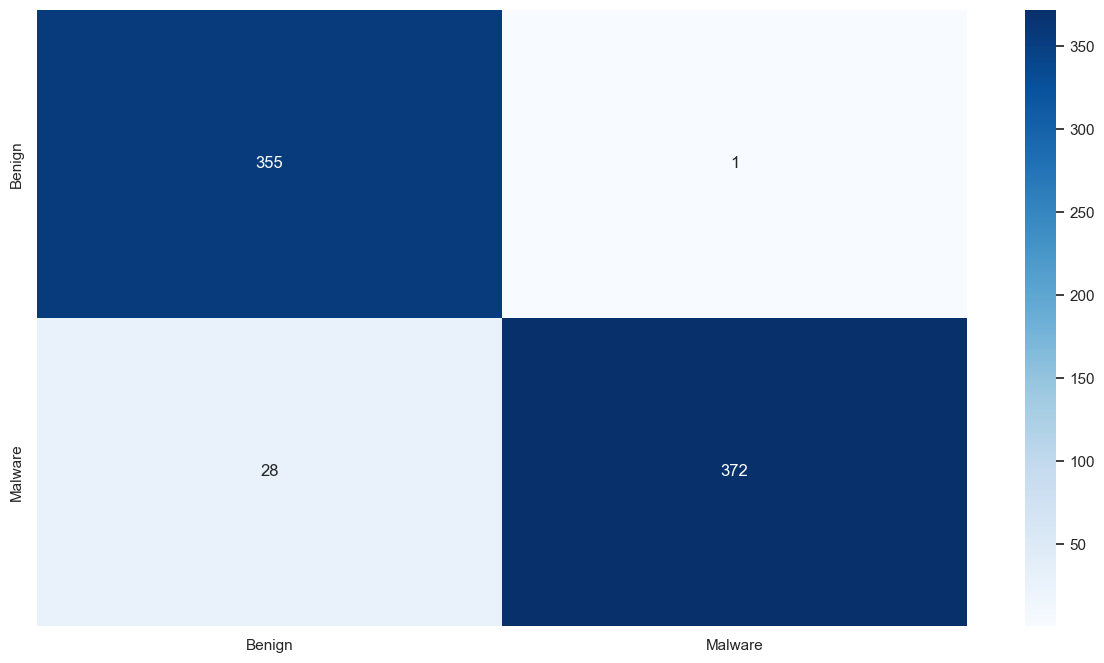

In [25]:
# We choose our model of choice and set it's hyper parameters you can change anything
clf = RandomForestClassifier(n_estimators=380)

# Train Model
clf.fit(X_train, y_train)

# Check data balance and variety
print(sorted(Counter(y_train).items()))
ResultPrintout(clf)

Feature: 0, Score: 0.02865
Feature: 1, Score: 0.01748
Feature: 2, Score: 0.01475
Feature: 3, Score: 0.02212
Feature: 4, Score: 0.00621
Feature: 5, Score: 0.03471
Feature: 6, Score: 0.05415
Feature: 7, Score: 0.02571
Feature: 8, Score: 0.01302
Feature: 9, Score: 0.32975
Feature: 10, Score: 0.11248
Feature: 11, Score: 0.14779
Feature: 12, Score: 0.04366
Feature: 13, Score: 0.10516
Feature: 14, Score: 0.01507
Feature: 15, Score: 0.01443
Feature: 16, Score: 0.01486


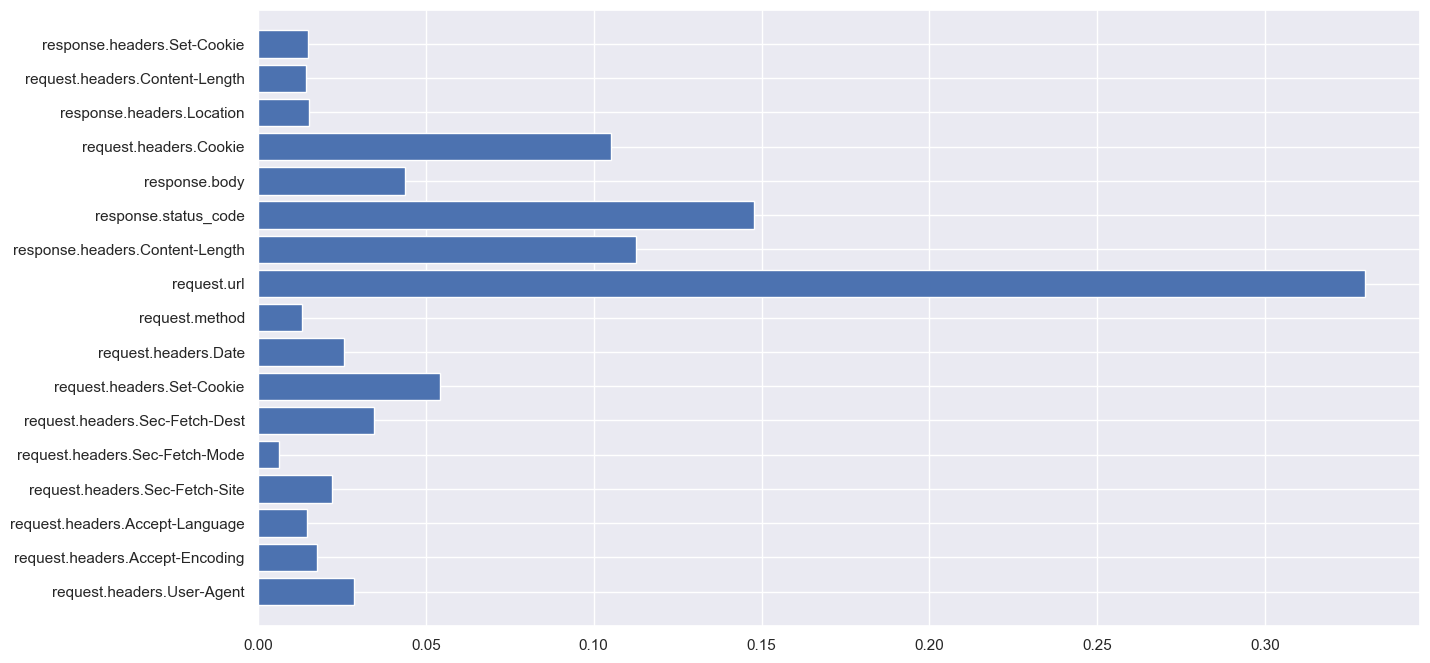

In [26]:
# https://machinelearningmastery.com/calculate-feature-importance-with-python/
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# get importance
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
pyplot.yticks(np.arange(X_train.shape[1]), features_list)
pyplot.ylim([-1, X_train.shape[1]])
pyplot.barh(range(X_train.shape[1]), clf.feature_importances_, align="center")
pyplot.show()

[('Benign', 1662), ('Malware', 1864)]
              precision    recall  f1-score   support

      Benign    0.92913   0.99438   0.96065       356
     Malware    0.99467   0.93250   0.96258       400

    accuracy                        0.96164       756
   macro avg    0.96190   0.96344   0.96162       756
weighted avg    0.96381   0.96164   0.96167       756



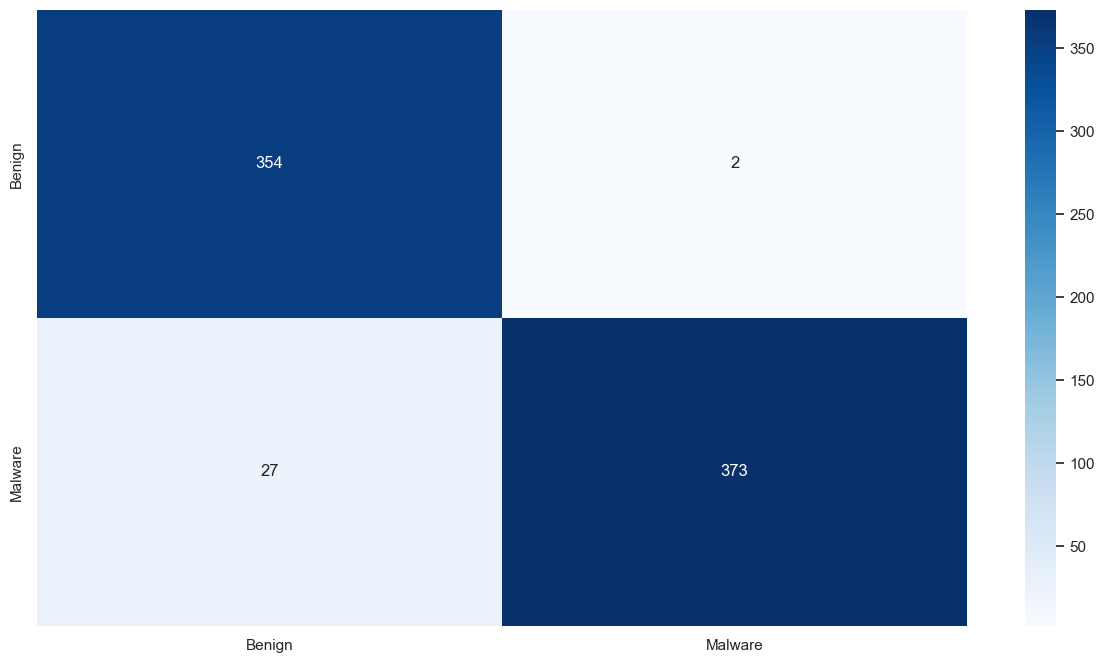

In [27]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

# We choose our model of choice and set it's hyper parameters you can change anything
rfc = RandomForestClassifier()

parameters = {"n_estimators": [100,150,250,275,290,300,325,350]}

# GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid
rfc = GridSearchCV(rfc, parameters)
# Train Model
rfc.fit(X_train, y_train)

# # Check data balance and variety
print(sorted(Counter(y_train).items()))
rfc = rfc.best_estimator_
ResultPrintout(rfc)

Feature: 0, Score: 0.02744
Feature: 1, Score: 0.01747
Feature: 2, Score: 0.01484
Feature: 3, Score: 0.02152
Feature: 4, Score: 0.00643
Feature: 5, Score: 0.03518
Feature: 6, Score: 0.05364
Feature: 7, Score: 0.02668
Feature: 8, Score: 0.01266
Feature: 9, Score: 0.33792
Feature: 10, Score: 0.10366
Feature: 11, Score: 0.14879
Feature: 12, Score: 0.04573
Feature: 13, Score: 0.10434
Feature: 14, Score: 0.01664
Feature: 15, Score: 0.01240
Feature: 16, Score: 0.01464


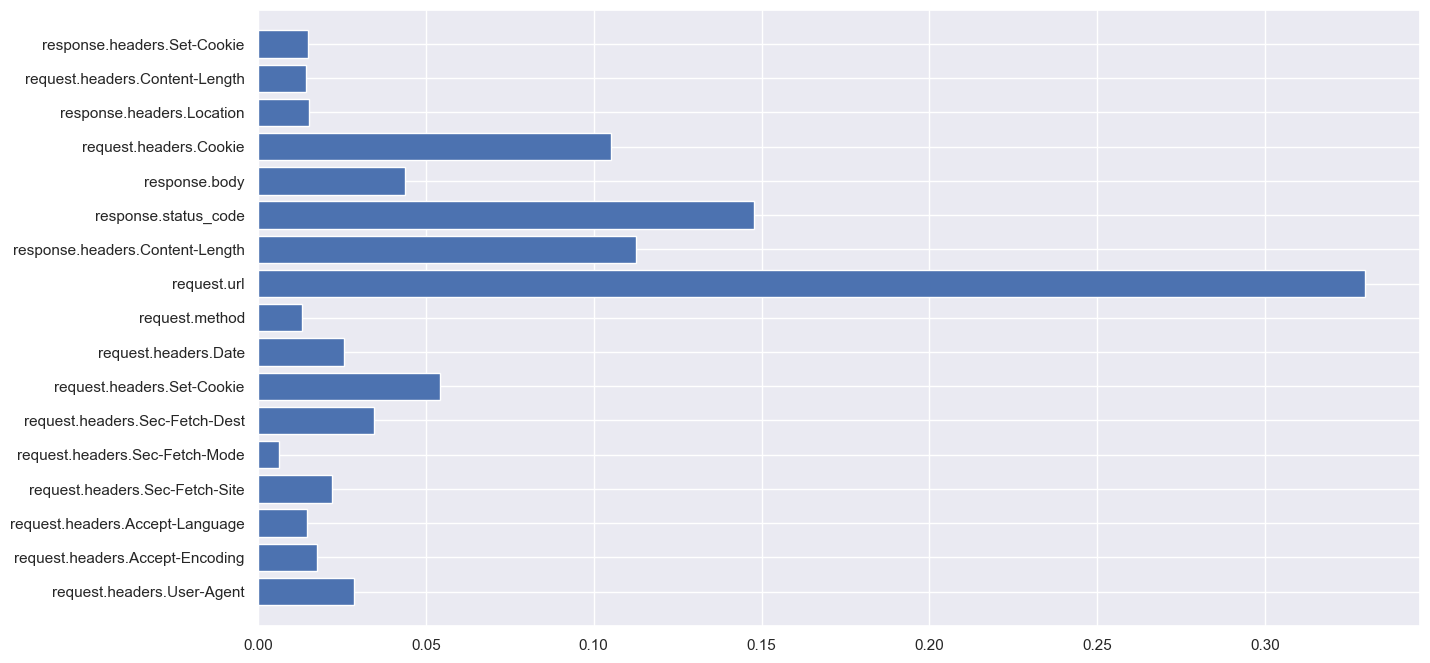

In [28]:
# https://machinelearningmastery.com/calculate-feature-importance-with-python/
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# get importance
importance = rfc.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
pyplot.yticks(np.arange(X_train.shape[1]), features_list)
pyplot.ylim([-1, X_train.shape[1]])
pyplot.barh(range(X_train.shape[1]), clf.feature_importances_, align="center")
pyplot.show()

In [29]:
print(df['response.headers.Content-Length'])

0        72
1        41
2       105
3        30
4        41
       ... 
4277    211
4278     36
4279    211
4280     41
4281     41
Name: response.headers.Content-Length, Length: 4282, dtype: int64


In [30]:
# import xgboost as xgb
# # We choose our model of choice and set it's hyper parameters you can change anything
# xg = xgb.XGBClassifier(objective="binary:logistic", random_state=45)
# xg.fit(X_train, y_train)

# # Check data balance and variety
# print(sorted(Counter(y_train).items()))
# ResultPrintout(xg)

In [31]:
# # https://machinelearningmastery.com/calculate-feature-importance-with-python/
# # random forest for feature importance on a regression problem
# from sklearn.datasets import make_regression
# from sklearn.ensemble import RandomForestRegressor
# from matplotlib import pyplot

# # get importance
# importance = xg.feature_importances_
# # summarize feature importance
# for i,v in enumerate(importance):
#  print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# # pyplot.bar([x for x in range(len(importance))], importance)
# pyplot.yticks(np.arange(X_train.shape[1]), features_list)
# pyplot.ylim([-1, X_train.shape[1]])
# pyplot.barh(range(X_train.shape[1]), clf.feature_importances_, align="center")
# pyplot.show()

[('Benign', 1662), ('Malware', 1864)]
              precision    recall  f1-score   support

      Benign    0.93931   1.00000   0.96871       356
     Malware    1.00000   0.94250   0.97040       400

    accuracy                        0.96958       756
   macro avg    0.96966   0.97125   0.96955       756
weighted avg    0.97142   0.96958   0.96960       756



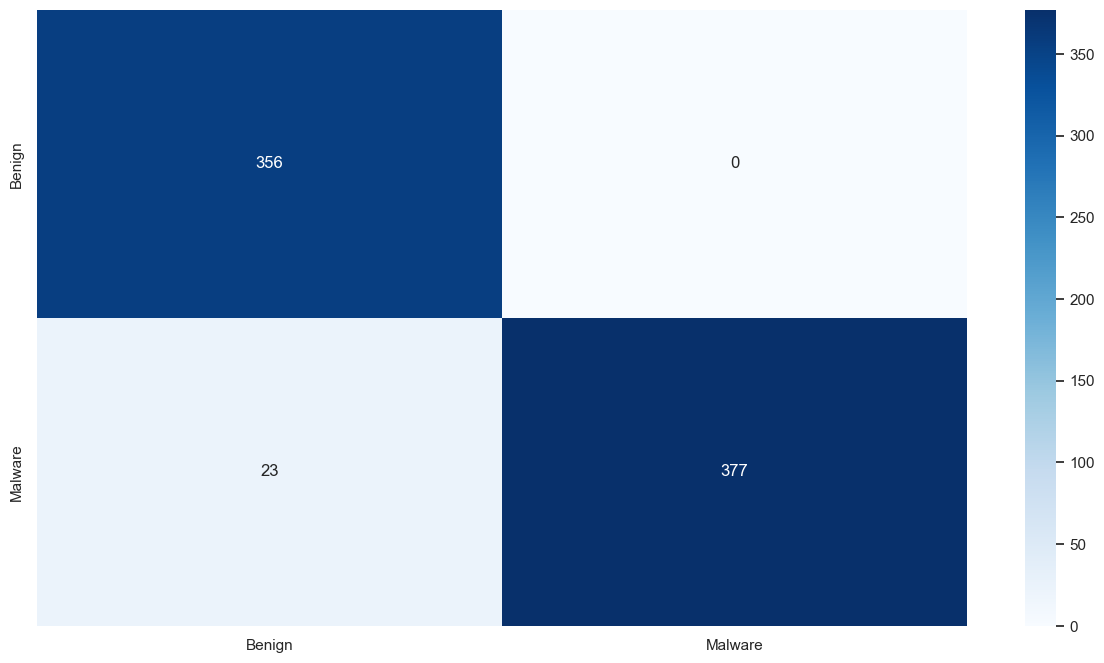

In [32]:
from sklearn.ensemble import GradientBoostingClassifier
Gradient_Boosting =  GradientBoostingClassifier(random_state=42)
# We choose our model of choice and set it's hyper parameters you can change anything
Gradient_Boosting.fit(X_train, y_train)

# Check data balance and variety
print(sorted(Counter(y_train).items()))
ResultPrintout(Gradient_Boosting)

Feature: 0, Score: 0.00034
Feature: 1, Score: 0.02580
Feature: 2, Score: 0.00063
Feature: 3, Score: 0.03440
Feature: 4, Score: 0.00021
Feature: 5, Score: 0.05044
Feature: 6, Score: 0.00550
Feature: 7, Score: 0.00137
Feature: 8, Score: 0.00009
Feature: 9, Score: 0.40165
Feature: 10, Score: 0.00090
Feature: 11, Score: 0.11250
Feature: 12, Score: 0.00008
Feature: 13, Score: 0.36610
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000


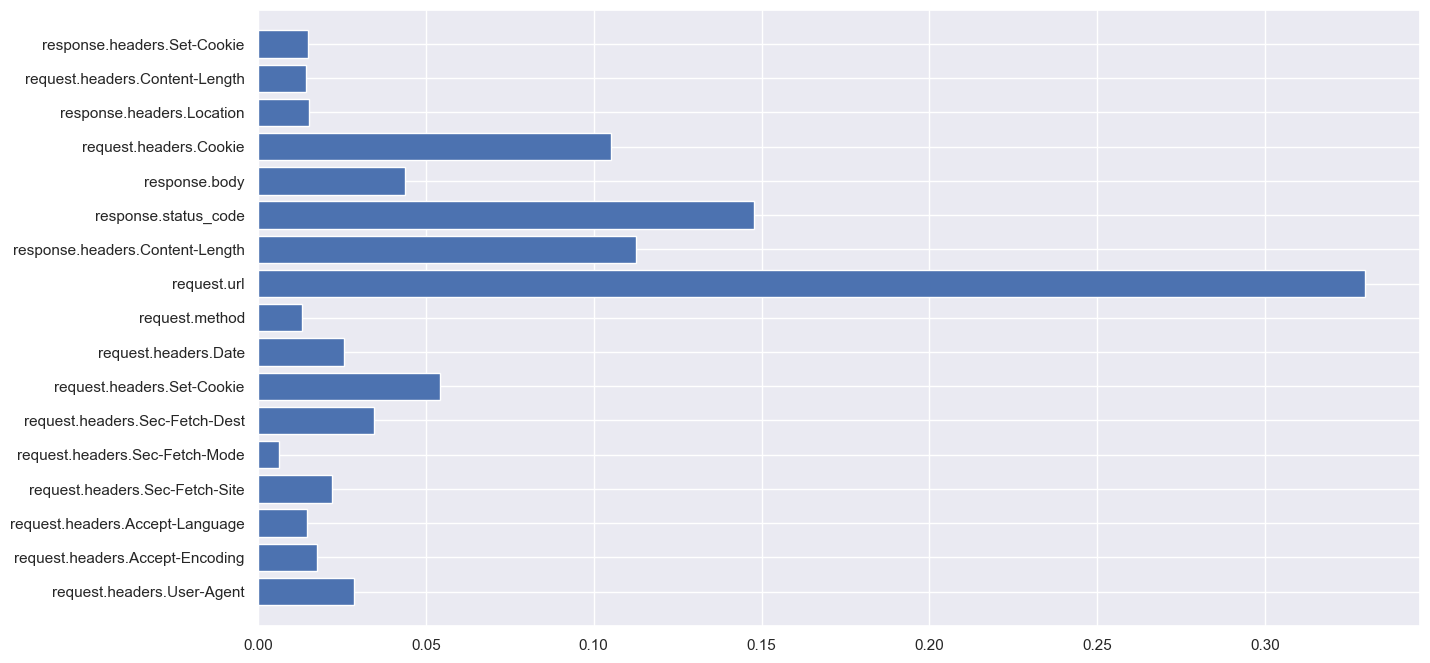

In [33]:
# https://machinelearningmastery.com/calculate-feature-importance-with-python/
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# get importance
importance = Gradient_Boosting.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
pyplot.yticks(np.arange(X_train.shape[1]), features_list)
pyplot.ylim([-1, X_train.shape[1]])
pyplot.barh(range(X_train.shape[1]), clf.feature_importances_, align="center")
pyplot.show()

Feature: 0, Score: 0.00034
Feature: 1, Score: 0.02580
Feature: 2, Score: 0.00063
Feature: 3, Score: 0.03440
Feature: 4, Score: 0.00021
Feature: 5, Score: 0.05044
Feature: 6, Score: 0.00550
Feature: 7, Score: 0.00137
Feature: 8, Score: 0.00009
Feature: 9, Score: 0.40165
Feature: 10, Score: 0.00090
Feature: 11, Score: 0.11250
Feature: 12, Score: 0.00008
Feature: 13, Score: 0.36610
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000


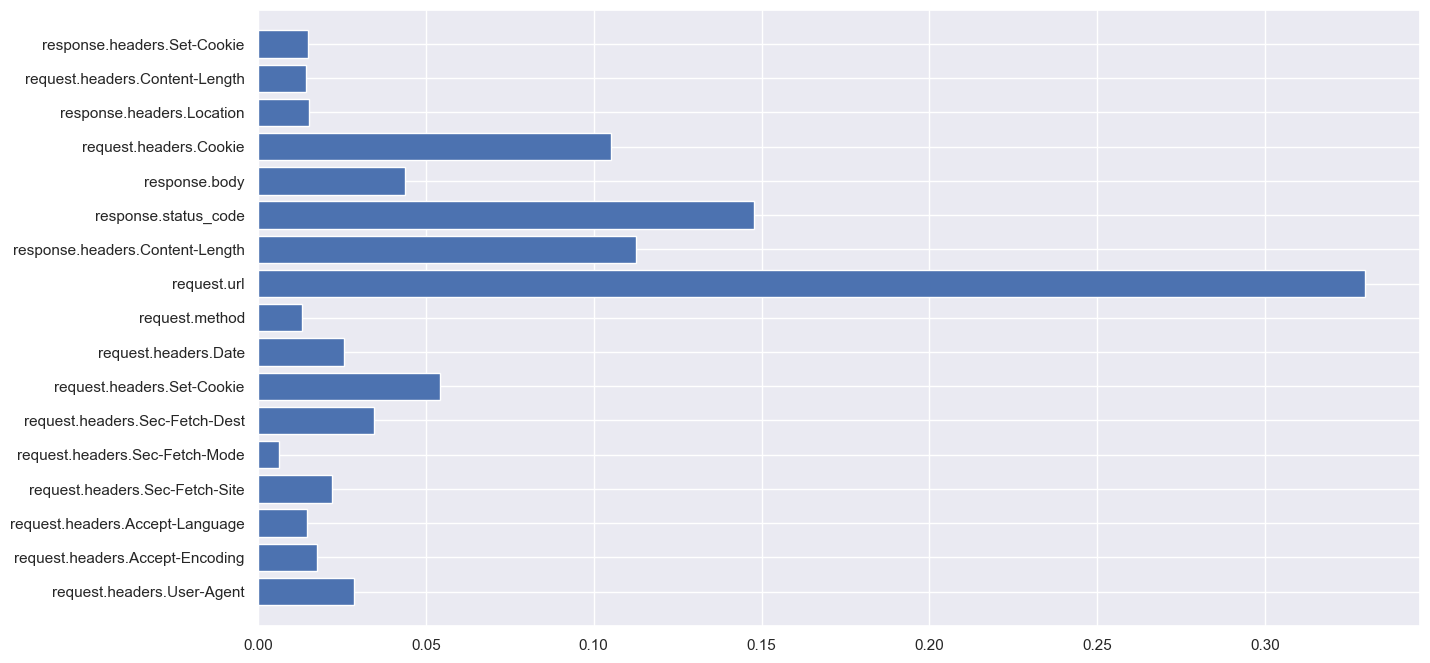

In [34]:
# https://machinelearningmastery.com/calculate-feature-importance-with-python/
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# get importance
importance = Gradient_Boosting.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
pyplot.yticks(np.arange(X_train.shape[1]), features_list)
pyplot.ylim([-1, X_train.shape[1]])
pyplot.barh(range(X_train.shape[1]), clf.feature_importances_, align="center")
pyplot.show()

[('Benign', 1662), ('Malware', 1864)]
              precision    recall  f1-score   support

      Benign    0.93438   1.00000   0.96608       356
     Malware    1.00000   0.93750   0.96774       400

    accuracy                        0.96693       756
   macro avg    0.96719   0.96875   0.96691       756
weighted avg    0.96910   0.96693   0.96696       756



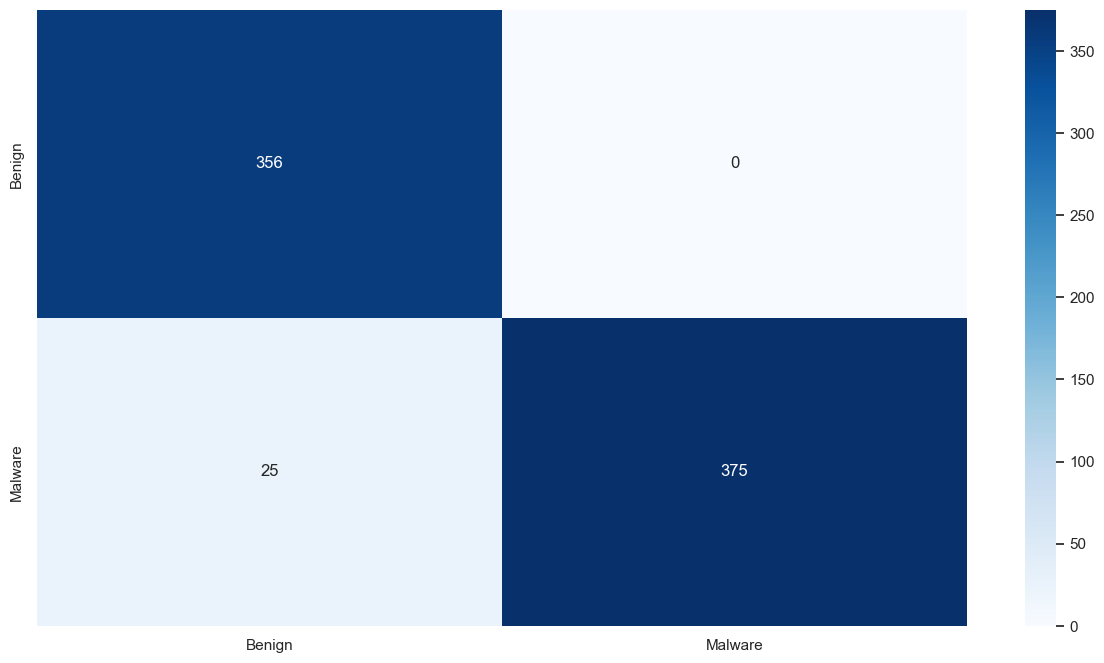

In [35]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
from sklearn.ensemble import HistGradientBoostingClassifier
# We choose our model of choice and set it's hyper parameters you can change anything
hgbc = HistGradientBoostingClassifier()

#  The random_state in these algorithms controls the randomness involved during the node splitting process by searching for the best feature
parameters = {"min_samples_leaf": [1,5,10,15,20],
              "max_iter":[1,2,3,4,5,10,20,50]
             }

# GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid
hgbc = GridSearchCV(hgbc, parameters)
# Train Model
hgbc.fit(X_train, y_train)

# # Check data balance and variety
print(sorted(Counter(y_train).items()))
hgbc = hgbc.best_estimator_
ResultPrintout(hgbc)

C:\Users\97252\anaconda3\lib\site-packages\xgboost\compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
              precision    recall  f1-score   support

      Benign    0.93931   1.00000   0.96871       356
     Malware    1.00000   0.94250   0.97040       400

    accuracy                        0.96958       756
   macro avg    0.96966   0.97125   0.96955       756
weighted avg    0.97142   0.96958   0.96960       756

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
              p

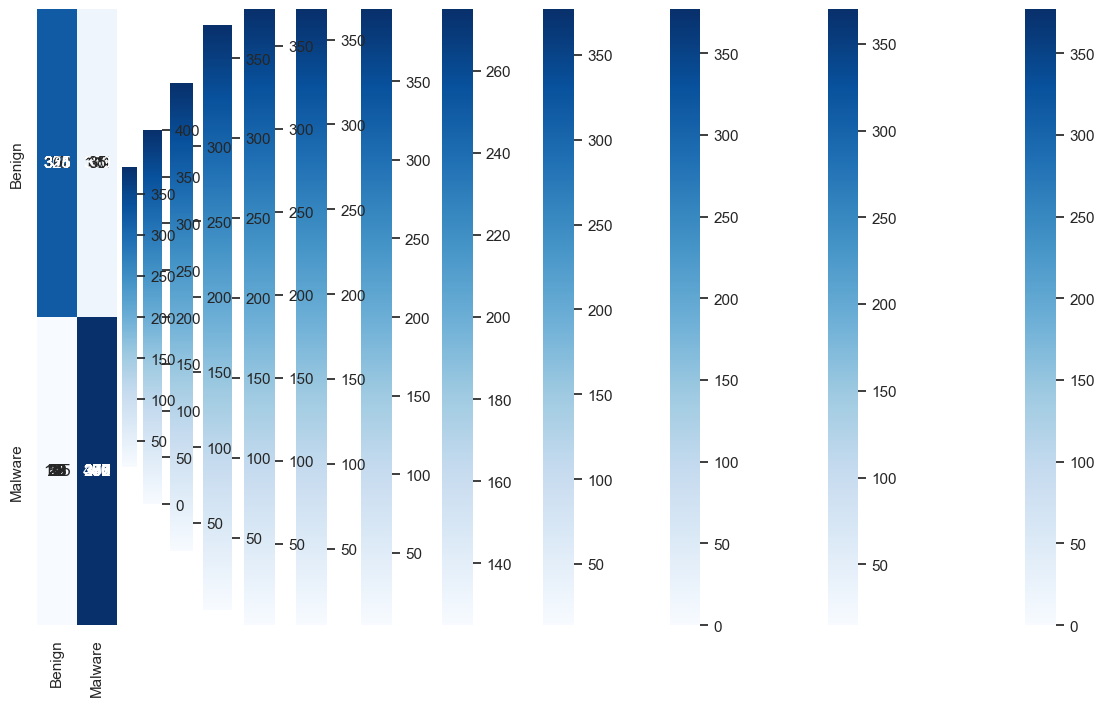

In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from timeit import timeit
import xgboost 
import sklearn
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline


Logistic_Regression =  LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

Decision_Tree =DecisionTreeClassifier(random_state=42, class_weight='balanced')

Random_Forest =  RandomForestClassifier(random_state=42, class_weight='balanced')

Extra_Trees=  ExtraTreesClassifier(random_state=42, class_weight='balanced')

Gradient_Boosting =  GradientBoostingClassifier(random_state=42)

Hist_Gradient_Boosting =  HistGradientBoostingClassifier(random_state=42)

AdaBoost = AdaBoostClassifier(random_state=42)

SGD = SGDClassifier(random_state=42, class_weight='balanced')

SVC =SVC(class_weight='balanced', random_state=42)

Nearest_Neighbor = KNeighborsClassifier(100)

Perceptron = Perceptron(random_state=42)
xgb=xgboost.sklearn.XGBClassifier(max_depth=2)
models={xgb,Logistic_Regression,Decision_Tree,Random_Forest,Extra_Trees,Gradient_Boosting,Hist_Gradient_Boosting,AdaBoost,SGD,SVC,Nearest_Neighbor,Perceptron}

for model in models:
#     %time scores = evaluate_model(model, X, y)
#     results.append(scores)
#     names.append(name)
#     print('* %s Score = %.3f StdDev = (%.3f)' % (name, np.mean(scores), np.std(scores)), '\n')
#     hgbc2 = HistGradientBoostingClassifier()

   
    # Train Model
    model.fit(X_train, y_train)
    print(model)
    # # Check data balance and variety
    ResultPrintout(model)


[('Benign', 1662), ('Malware', 1864)]
              precision    recall  f1-score   support

      Benign    0.93931   1.00000   0.96871       356
     Malware    1.00000   0.94250   0.97040       400

    accuracy                        0.96958       756
   macro avg    0.96966   0.97125   0.96955       756
weighted avg    0.97142   0.96958   0.96960       756



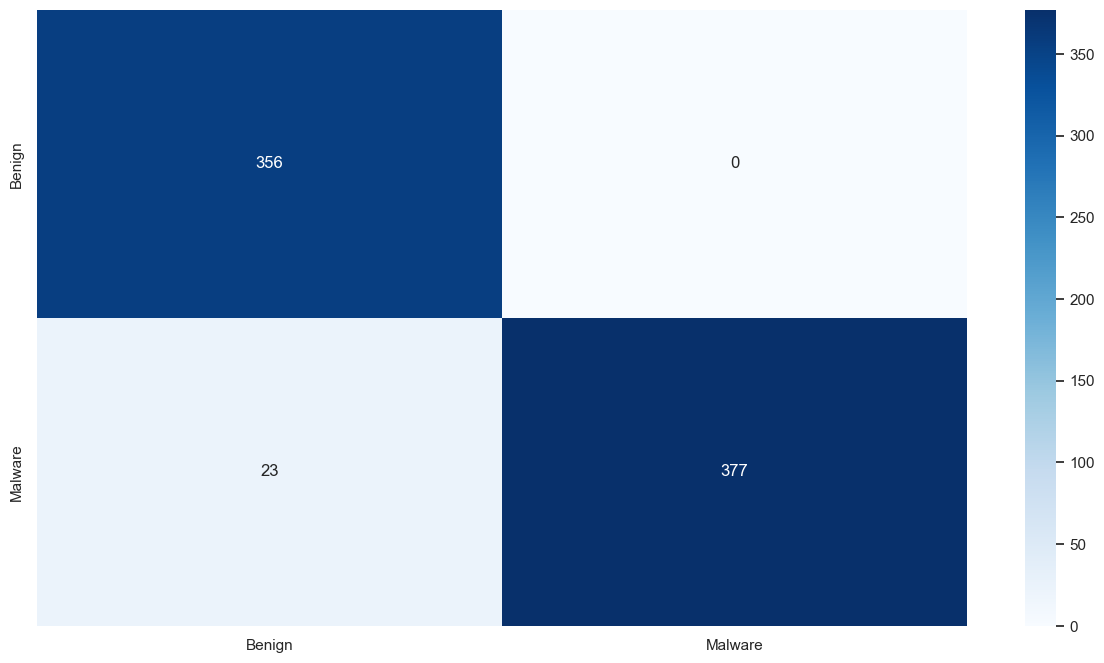

In [37]:

# We choose our model of choice and set it's hyper parameters you can change anything
xg=xgboost.sklearn.XGBClassifier(max_depth=2,learning_rate=0.355555)


# Train Model
xg.fit(X_train, y_train)

# # Check data balance and variety
print(sorted(Counter(y_train).items()))

ResultPrintout(xg)


In [38]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
from sklearn.metrics import accuracy_score
best=0
m=None
# ,gbc
models={clf,rfc,Gradient_Boosting,hgbc,xgb,Logistic_Regression,Decision_Tree,Random_Forest,Extra_Trees,Gradient_Boosting,Hist_Gradient_Boosting,AdaBoost,SGD,SVC,Nearest_Neighbor,Perceptron}

for i in models:
    print(i)
    sns.set(rc={'figure.figsize':(15,8)})
    predictions = i.predict(X_test)
    true_labels = y_test
    print(accuracy_score(true_labels, predictions)*100)
    if accuracy_score(true_labels, predictions)*100 > best:
        best=accuracy_score(true_labels, predictions)*100
        m=i
#         print(best)
#         print(m)
        
print("-------")
print(best)
print(m)

RandomForestClassifier()
96.16402116402116
LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
94.04761904761905
GradientBoostingClassifier(random_state=42)
96.95767195767195
AdaBoostClassifier(random_state=42)
95.1058201058201
HistGradientBoostingClassifier(max_iter=20, min_samples_leaf=5)
96.6931216931217
SGDClassifier(class_weight='balanced', random_state=42)
59.12698412698413
RandomForestClassifier(n_estimators=380)
96.16402116402116
SVC(class_weight='balanced', random_state=42)
54.629629629629626
DecisionTreeClassifier(class_weight='balanced', random_state=42)
92.98941798941799
HistGradientBoostingClassifier(random_state=42)
95.1058201058201
RandomForestClassifier(class_weight='balanced', random_state=42)
96.16402116402116
ExtraTreesClassifier(class_weight='balanced', random_state=42)
95.5026455026455
KNeighborsClassifier(n_neighbors=100)
88.22751322751323
Perceptron(random_state=42)
52.910052910052904
XGBClassifier(base_score=0.5, booster='gbtree', colsamp

# Test

In [39]:
with open(f'./dataset_{str(dataset_number)}_val.json') as file:
    raw_ds = json.load(file)
test_df = pd.json_normalize(raw_ds, max_level=2)

# Preprocess the validation dataset, remember that here you don't have the labels
for column in test_df.columns[test_df.isna().any()].tolist():
    #df.drop(column, axis=1, inplace=True)
    test_df[column] = test_df[column].fillna('None')
test_df = vectorize_df(test_df)
change_url(test_df)
# Predict with your model
X = test_df[features_list].to_numpy()
# for i in X.length():
#     if X[i] == 'none':
#         X[i] = 0
print(m)
predictions = m.predict(X)


http://127.0.0.1:5000/orders/check/exists/9701
http://127.0.0.1:5000/categories/check/number/5485
http://127.0.0.1:5000/states/6885
http://127.0.0.1:5000/states/10070
http://127.0.0.1:5000/about/greet
http://127.0.0.1:5000/cookielogin
http://127.0.0.1:5000/greet/%7B%7Bget_flashed_messages.__globals__.__builtins__.__import__('os').system%7D%7D
url_length
http://127.0.0.1:5000/login/admin/password/1358
http://127.0.0.1:5000/orders/get/country?country=';SELECT%20*%20FROM%20us_states%20limit59--
url_length
http://127.0.0.1:5000/greet/3538
http://127.0.0.1:5000/orders/check/exists/9845
http://127.0.0.1:5000/states/get/region/2231
http://127.0.0.1:5000/categories/check/all
http://127.0.0.1:5000/orders/get/random/9127
http://127.0.0.1:5000/orders/get/id/7794
http://127.0.0.1:5000/about/random_page
http://127.0.0.1:5000/login/user?username=Edward&password=PhilipJohnson'%20or%20'GeorgeMetz'='GeorgeMetz
url_length
http://127.0.0.1:5000/states/get/region/1722
http://127.0.0.1:5000/static/download

# Save your predictions

In [40]:
# Save your preditions
enc = LabelEncoder()
np.savetxt(f'./dataset_{str(dataset_number)}_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')